In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
os.listdir('data')

['AllNO2_QH.csv',
 'AllPM_QH.csv',
 'Env_QH.csv',
 'GradientTemp_15minDataSet.csv',
 'micro_sud3.pkl',
 'micro_sud3_normalized.pkl',
 'Patm_15minDataSet.csv',
 'pickles']

In [3]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    i = look_back
    while True:
        sequence = df.iloc[i - look_back:i]
        yield np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8) , np.array(sequence['NO2_ref'])
        i += 1
        if i == len(df):
            i = look_back
            
def dataframe_to_xy_test(df, look_back):
    X_test, y_test = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X_test.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y_test.append(np.array(sequence['NO2_ref']))
        i += 1
        if i == len(df):
            break
            
    return np.array(X_test), np.array(y_test)
            
        
df_train, df_test = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train = dataframe_to_xy(df_train, 10)
X_valid = dataframe_to_xy(df_valid, 10)
X_test, y_test = dataframe_to_xy_test(df_test, 10)

In [4]:
def dataframe_to_xy_no_generator(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [5]:
X_train, y_train = dataframe_to_xy_no_generator(df_train, 24)
X_valid, y_valid = dataframe_to_xy_no_generator(df_valid, 24)
X_test, y_test = dataframe_to_xy_no_generator(df_test, 24)

In [6]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

In [7]:
model = simple_rnn_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=100)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 1s 461us/step - loss: 3394.1620 - val_loss: 3102.8254
Epoch 2/5000
1102/1102 [==============================] - 0s 139us/step - loss: 3299.7631 - val_loss: 3034.3263
Epoch 3/5000
1102/1102 [==============================] - 0s 138us/step - loss: 3151.6829 - val_loss: 2836.0215
Epoch 4/5000
1102/1102 [==============================] - 0s 135us/step - loss: 2996.2649 - val_loss: 2708.3460
Epoch 5/5000
1102/1102 [==============================] - 0s 131us/step - loss: 2859.8667 - val_loss: 2626.9390
Epoch 6/5000
1102/1102 [==============================] - 0s 137us/step - loss: 2741.6675 - val_loss: 2540.4159
Epoch 7/5000
1102/1102 [==============================] - 0s 140us/step - loss: 2640.4198 - val_loss: 2468.5619
Epoch 8/5000
1102/1102 [==============================] - 0s 130us/step - loss: 2556.1492 - val_loss: 2402.8446
Epoch 9/5000
1102/1102 [==============================] -

1102/1102 [==============================] - 0s 139us/step - loss: 551.0460 - val_loss: 823.8172
Epoch 74/5000
1102/1102 [==============================] - 0s 137us/step - loss: 541.0554 - val_loss: 830.5655
Epoch 75/5000
1102/1102 [==============================] - 0s 137us/step - loss: 528.8282 - val_loss: 786.3560
Epoch 76/5000
1102/1102 [==============================] - 0s 146us/step - loss: 519.7165 - val_loss: 830.4330
Epoch 77/5000
1102/1102 [==============================] - 0s 146us/step - loss: 512.3145 - val_loss: 801.7390
Epoch 78/5000
1102/1102 [==============================] - 0s 135us/step - loss: 502.1762 - val_loss: 828.1358
Epoch 79/5000
1102/1102 [==============================] - 0s 137us/step - loss: 491.5056 - val_loss: 830.4856
Epoch 80/5000
1102/1102 [==============================] - 0s 131us/step - loss: 489.5058 - val_loss: 794.0148
Epoch 81/5000
1102/1102 [==============================] - 0s 131us/step - loss: 480.9043 - val_loss: 750.8693
Epoch 82/5000
1

1102/1102 [==============================] - 0s 134us/step - loss: 207.0199 - val_loss: 617.0464
Epoch 147/5000
1102/1102 [==============================] - 0s 131us/step - loss: 206.1686 - val_loss: 622.6275
Epoch 148/5000
1102/1102 [==============================] - 0s 138us/step - loss: 205.3437 - val_loss: 634.8821
Epoch 149/5000
1102/1102 [==============================] - 0s 145us/step - loss: 202.5993 - val_loss: 662.6523
Epoch 150/5000
1102/1102 [==============================] - 0s 147us/step - loss: 203.0111 - val_loss: 626.5987
Epoch 151/5000
1102/1102 [==============================] - 0s 136us/step - loss: 202.9494 - val_loss: 665.6507
Epoch 152/5000
1102/1102 [==============================] - 0s 132us/step - loss: 207.4746 - val_loss: 625.3159
Epoch 153/5000
1102/1102 [==============================] - 0s 141us/step - loss: 199.3075 - val_loss: 617.5032
Epoch 154/5000
1102/1102 [==============================] - 0s 149us/step - loss: 198.5156 - val_loss: 635.3098
Epoch 1

1102/1102 [==============================] - 0s 137us/step - loss: 150.9562 - val_loss: 576.3632
Epoch 220/5000
1102/1102 [==============================] - 0s 128us/step - loss: 150.0269 - val_loss: 547.5157
Epoch 221/5000
1102/1102 [==============================] - 0s 135us/step - loss: 153.2508 - val_loss: 526.8258
Epoch 222/5000
1102/1102 [==============================] - 0s 129us/step - loss: 151.4020 - val_loss: 523.4133
Epoch 223/5000
1102/1102 [==============================] - 0s 131us/step - loss: 147.9867 - val_loss: 548.8681
Epoch 224/5000
1102/1102 [==============================] - 0s 127us/step - loss: 147.4972 - val_loss: 520.9580
Epoch 225/5000
1102/1102 [==============================] - 0s 134us/step - loss: 145.6798 - val_loss: 569.1738
Epoch 226/5000
1102/1102 [==============================] - 0s 138us/step - loss: 148.6439 - val_loss: 548.9914
Epoch 227/5000
1102/1102 [==============================] - 0s 147us/step - loss: 148.2880 - val_loss: 587.3492
Epoch 2

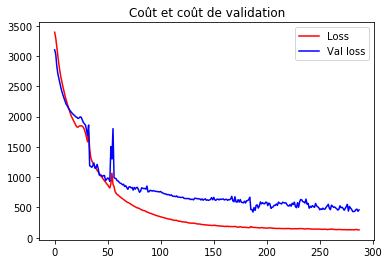

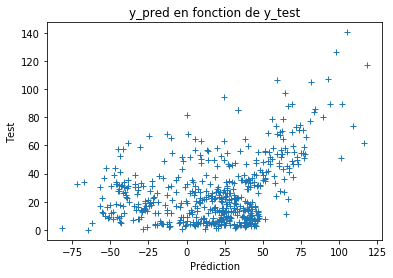

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=100)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 1s 1ms/step - loss: 3399.5164 - val_loss: 3084.8737
Epoch 2/5000
1102/1102 [==============================] - 0s 427us/step - loss: 3286.5706 - val_loss: 2877.5932
Epoch 3/5000
1102/1102 [==============================] - 0s 422us/step - loss: 3045.2171 - val_loss: 2674.8840
Epoch 4/5000
1102/1102 [==============================] - 0s 442us/step - loss: 2883.3010 - val_loss: 2547.7213
Epoch 5/5000
1102/1102 [==============================] - 0s 435us/step - loss: 2762.1995 - val_loss: 2441.2963
Epoch 6/5000
1102/1102 [==============================] - 0s 426us/step - loss: 2657.0196 - val_loss: 2344.4194
Epoch 7/5000
1102/1102 [==============================] - 0s 423us/step - loss: 2560.7774 - val_loss: 2256.6717
Epoch 8/5000
1102/1102 [==============================] - 0s 424us/step - loss: 2471.4554 - val_loss: 2174.9194
Epoch 9/5000
1102/1102 [==============================] - 0

1102/1102 [==============================] - 0s 425us/step - loss: 495.8344 - val_loss: 702.2511
Epoch 74/5000
1102/1102 [==============================] - 0s 422us/step - loss: 485.8842 - val_loss: 697.7724
Epoch 75/5000
1102/1102 [==============================] - 0s 425us/step - loss: 476.2242 - val_loss: 691.2290
Epoch 76/5000
1102/1102 [==============================] - 0s 420us/step - loss: 469.2001 - val_loss: 661.6556
Epoch 77/5000
1102/1102 [==============================] - 0s 427us/step - loss: 465.9222 - val_loss: 661.8804
Epoch 78/5000
1102/1102 [==============================] - 0s 422us/step - loss: 450.5903 - val_loss: 660.4130
Epoch 79/5000
1102/1102 [==============================] - 0s 424us/step - loss: 444.3292 - val_loss: 635.2052
Epoch 80/5000
1102/1102 [==============================] - 0s 422us/step - loss: 432.3040 - val_loss: 641.1120
Epoch 81/5000
1102/1102 [==============================] - 0s 424us/step - loss: 423.6828 - val_loss: 649.2738
Epoch 82/5000
1

1102/1102 [==============================] - 0s 427us/step - loss: 166.1069 - val_loss: 481.9047
Epoch 147/5000
1102/1102 [==============================] - 0s 423us/step - loss: 163.9842 - val_loss: 483.3685
Epoch 148/5000
1102/1102 [==============================] - 0s 422us/step - loss: 165.6646 - val_loss: 483.2896
Epoch 149/5000
1102/1102 [==============================] - 0s 424us/step - loss: 160.7515 - val_loss: 479.3540
Epoch 150/5000
1102/1102 [==============================] - 0s 423us/step - loss: 159.7368 - val_loss: 494.8845
Epoch 151/5000
1102/1102 [==============================] - 0s 422us/step - loss: 156.9231 - val_loss: 478.0188
Epoch 152/5000
1102/1102 [==============================] - 0s 425us/step - loss: 156.6403 - val_loss: 484.2990
Epoch 153/5000
1102/1102 [==============================] - 0s 422us/step - loss: 153.8569 - val_loss: 488.5813
Epoch 154/5000
1102/1102 [==============================] - 0s 423us/step - loss: 151.8834 - val_loss: 485.3413
Epoch 1

1102/1102 [==============================] - 0s 426us/step - loss: 111.2692 - val_loss: 491.3285
Epoch 220/5000
1102/1102 [==============================] - 0s 424us/step - loss: 109.2866 - val_loss: 488.4670
Epoch 221/5000
1102/1102 [==============================] - 0s 423us/step - loss: 110.1576 - val_loss: 489.8429
Epoch 222/5000
1102/1102 [==============================] - 0s 439us/step - loss: 109.1748 - val_loss: 486.6205
Epoch 223/5000
1102/1102 [==============================] - 0s 449us/step - loss: 107.9227 - val_loss: 499.8225
Epoch 224/5000
1102/1102 [==============================] - 0s 425us/step - loss: 108.2859 - val_loss: 494.2913
Epoch 225/5000
1102/1102 [==============================] - 0s 423us/step - loss: 107.3186 - val_loss: 496.2457
Epoch 226/5000
1102/1102 [==============================] - 0s 424us/step - loss: 107.0311 - val_loss: 504.1110
Epoch 227/5000
1102/1102 [==============================] - 0s 424us/step - loss: 105.5141 - val_loss: 490.0990
Epoch 2

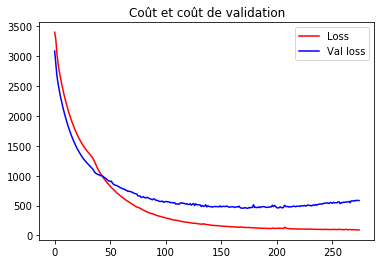

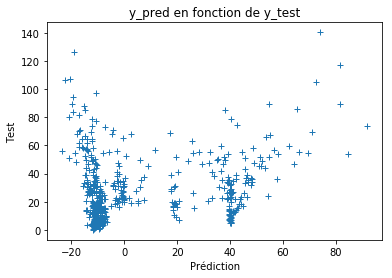

In [12]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=100)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1)

Train on 1102 samples, validate on 539 samples
Epoch 1/5000
1102/1102 [==============================] - 1s 1ms/step - loss: 3394.0852 - val_loss: 3097.2924
Epoch 2/5000
1102/1102 [==============================] - 0s 385us/step - loss: 3296.5248 - val_loss: 2938.2430
Epoch 3/5000
1102/1102 [==============================] - 0s 402us/step - loss: 3055.8389 - val_loss: 2703.0514
Epoch 4/5000
1102/1102 [==============================] - 0s 359us/step - loss: 2898.0115 - val_loss: 2578.2331
Epoch 5/5000
1102/1102 [==============================] - 0s 365us/step - loss: 2776.1035 - val_loss: 2475.3833
Epoch 6/5000
1102/1102 [==============================] - 0s 376us/step - loss: 2669.2638 - val_loss: 2382.1334
Epoch 7/5000
1102/1102 [==============================] - 0s 359us/step - loss: 2572.1325 - val_loss: 2296.5795
Epoch 8/5000
1102/1102 [==============================] - 0s 351us/step - loss: 2482.3288 - val_loss: 2218.6098
Epoch 9/5000
1102/1102 [==============================] - 0

1102/1102 [==============================] - 0s 366us/step - loss: 530.0871 - val_loss: 566.5342
Epoch 74/5000
1102/1102 [==============================] - 0s 359us/step - loss: 517.7077 - val_loss: 561.0434
Epoch 75/5000
1102/1102 [==============================] - 0s 360us/step - loss: 506.8509 - val_loss: 552.2975
Epoch 76/5000
1102/1102 [==============================] - 0s 359us/step - loss: 497.0678 - val_loss: 543.9565
Epoch 77/5000
1102/1102 [==============================] - 0s 351us/step - loss: 484.9170 - val_loss: 542.6068
Epoch 78/5000
1102/1102 [==============================] - 0s 352us/step - loss: 476.5931 - val_loss: 533.4598
Epoch 79/5000
1102/1102 [==============================] - 0s 358us/step - loss: 466.2178 - val_loss: 529.8524
Epoch 80/5000
1102/1102 [==============================] - 0s 366us/step - loss: 458.2337 - val_loss: 526.7195
Epoch 81/5000
1102/1102 [==============================] - 0s 356us/step - loss: 450.9793 - val_loss: 514.1217
Epoch 82/5000
1

1102/1102 [==============================] - 0s 344us/step - loss: 176.8440 - val_loss: 391.9739
Epoch 147/5000
1102/1102 [==============================] - 0s 344us/step - loss: 173.8319 - val_loss: 395.9205
Epoch 148/5000
1102/1102 [==============================] - 0s 345us/step - loss: 171.9404 - val_loss: 394.0391
Epoch 149/5000
1102/1102 [==============================] - 0s 346us/step - loss: 171.6946 - val_loss: 396.8403
Epoch 150/5000
1102/1102 [==============================] - 0s 341us/step - loss: 170.1770 - val_loss: 419.7733
Epoch 151/5000
1102/1102 [==============================] - 0s 336us/step - loss: 169.7494 - val_loss: 405.1455
Epoch 152/5000
1102/1102 [==============================] - 0s 346us/step - loss: 166.7347 - val_loss: 401.6425
Epoch 153/5000
1102/1102 [==============================] - 0s 338us/step - loss: 165.5213 - val_loss: 407.1731
Epoch 154/5000
1102/1102 [==============================] - 0s 337us/step - loss: 163.5733 - val_loss: 405.0568
Epoch 1

1102/1102 [==============================] - 0s 358us/step - loss: 105.0515 - val_loss: 508.3225
Epoch 220/5000
1102/1102 [==============================] - 0s 357us/step - loss: 103.4965 - val_loss: 498.7943
Epoch 221/5000
1102/1102 [==============================] - 0s 336us/step - loss: 104.6498 - val_loss: 521.9957
Epoch 222/5000
1102/1102 [==============================] - 0s 344us/step - loss: 105.6220 - val_loss: 505.9962
Epoch 223/5000
1102/1102 [==============================] - 0s 344us/step - loss: 104.9510 - val_loss: 484.2470
Epoch 224/5000
1102/1102 [==============================] - 0s 340us/step - loss: 104.1180 - val_loss: 515.2820
Epoch 225/5000
1102/1102 [==============================] - 0s 356us/step - loss: 103.2516 - val_loss: 492.3996
Epoch 226/5000
1102/1102 [==============================] - 0s 345us/step - loss: 102.4203 - val_loss: 512.9091
Epoch 227/5000
1102/1102 [==============================] - 0s 339us/step - loss: 101.9507 - val_loss: 502.4555
Epoch 2

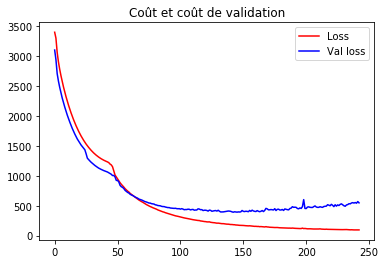

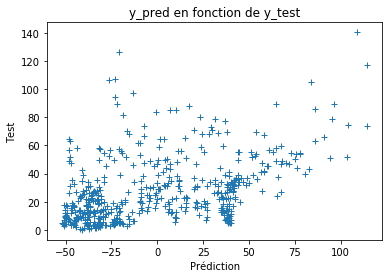

In [15]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()